# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [287]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB


<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [288]:
data = pd.read_csv('preprocessed_data.csv',nrows = 100000)
data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [358]:
#split features and class labels
Y = data['project_is_approved'].values
X = data.drop(['project_is_approved'],axis = 1)
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


In [359]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
#Splitting data into train and test
X_Train,X_Test,Y_Train,Y_Test = train_test_split(X,Y,test_size = .30,stratify = Y)
print(X_Train.shape,Y_Train.shape)
print(X_Test.shape,Y_Test.shape)

(70000, 8) (70000,)
(30000, 8) (30000,)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

### 1.3.1 Enconding essay using BoW

In [360]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    
#Encoding essay data using BoW
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4),max_features = 50000)
vectorizer.fit(X_Train['essay'].values)
X_Train_Essay_BoW = vectorizer.transform(X_Train['essay'].values)
X_Test_Essay_BoW = vectorizer.transform(X_Test['essay'].values)
print(X_Train_Essay_BoW.shape)
print(X_Test_Essay_BoW.shape)



(70000, 50000)
(30000, 50000)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [361]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    
#vectorize the Categorical features
#1. school_state
vectorizer_school_state = CountVectorizer();
vectorizer_school_state.fit(X_Train['school_state']);
print('Features extracted from school state are:',vectorizer_school_state.get_feature_names());
X_Train_School_State = vectorizer_school_state.transform(X_Train['school_state']);
X_Test_School_State = vectorizer_school_state.transform(X_Test['school_state']);
print('1st row from X_Train_School_State',X_Train_School_State[0]);
print('1st row from X_Test_School_State',X_Test_School_State[0]);

print('='*127)
#2. teacher_prefix

vectorizer_teacher_prefix = CountVectorizer();
vectorizer_teacher_prefix.fit(X_Train['teacher_prefix'])
print('Features extracted from teacher prefix are:',vectorizer_teacher_prefix.get_feature_names());
X_Train_Teacher_Prefix = vectorizer_teacher_prefix.transform(X_Train['teacher_prefix'])
X_Test_Teacher_Prefix = vectorizer_teacher_prefix.transform(X_Test['teacher_prefix'])
print('1st row from X_Train_Teacher_Prefix',X_Train_Teacher_Prefix[0]);
print('1st row from X_Test_Teacher_Prefix',X_Test_Teacher_Prefix[0]);

print('='*127)
#3.project_grade_category

vectorizer_project_grade_category = CountVectorizer();
vectorizer_project_grade_category.fit(X_Train['project_grade_category']);
X_Train_Project_Grade_Category = vectorizer_project_grade_category.transform(X_Train['project_grade_category']);
X_Test_Project_Grade_Category = vectorizer_project_grade_category.transform(X_Test['project_grade_category']);
print('Features extracted from project_grade_category are:',vectorizer_project_grade_category.get_feature_names());
print('1st row from X_Train_Project_Grade_Category',X_Train_Project_Grade_Category[0]);
print('1st row from X_Test_Project_Grade_Category',X_Test_Project_Grade_Category[0]);

print("="*127);

#4.clean_categories
vectorizer_clean_categories = CountVectorizer();
vectorizer_clean_categories.fit(X_Train['clean_categories']);
X_Train_Clean_Categories = vectorizer_clean_categories.transform(X_Train['clean_categories']);
X_Test_Clean_Categories = vectorizer_clean_categories.transform(X_Test['clean_categories']);
print('Features extracted from clean_categories are:',vectorizer_clean_categories.get_feature_names());
print('1st row from X_Train_Clean_Categories',X_Train_Clean_Categories[0]);
print('1st row from X_Test_Clean_Categories',X_Test_Clean_Categories[0]);

print("="*127);

#5.clean_subcategories

vectorizer_clean_subcategories = CountVectorizer();
vectorizer_clean_subcategories.fit(X_Train['clean_subcategories']);
X_Train_Clean_Subcategories = vectorizer_clean_subcategories.transform(X_Train['clean_subcategories']);
X_Test_Clean_Subcategories = vectorizer_clean_subcategories.transform(X_Test['clean_subcategories']);
print('Features extracted from clean_subcategories are:',vectorizer_clean_subcategories.get_feature_names());
print('1st row from X_Train_Clean_Subcategories',X_Train_Clean_Subcategories[0]);
print('1st row from X_Test_Clean_Subcategories',X_Test_Clean_Subcategories[0]);
print("="*127);

Features extracted from school state are: ['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
1st row from X_Train_School_State   (0, 40)	1
1st row from X_Test_School_State   (0, 3)	1
Features extracted from teacher prefix are: ['dr', 'mr', 'mrs', 'ms', 'teacher']
1st row from X_Train_Teacher_Prefix   (0, 2)	1
1st row from X_Test_Teacher_Prefix   (0, 3)	1
Features extracted from project_grade_category are: ['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
1st row from X_Train_Project_Grade_Category   (0, 3)	1
1st row from X_Test_Project_Grade_Category   (0, 2)	1
Features extracted from clean_categories are: ['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts'

### Normalizing Numerical features

In [362]:
#Numerical Features
#- price
#- teacher_number_of_previously_posted_projects

#1. price (normalize the feature)
normalize_price = Normalizer()
X_Train_Price = normalize_price.transform(X_Train['price'].values.reshape(1,-1)) 
X_Test_Price = normalize_price.transform(X_Test['price'].values.reshape(1,-1))
X_Train_Price = X_Train_Price.reshape(-1,1)
X_Test_Price = X_Test_Price.reshape(-1,1)
print(X_Train_Price.shape)
print(X_Test_Price.shape)

#2.teacher_number_of_previously_posted_projects
normalize_teacher_number_of_previously_posted_projects = Normalizer()
X_Train_TNOPPP = normalize_price.transform(X_Train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)) 
X_Test_TNOPPP = normalize_price.transform(X_Test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)) 
X_Train_TNOPPP = X_Train_TNOPPP.reshape(-1,1)
X_Test_TNOPPP = X_Test_TNOPPP.reshape(-1,1)
print(X_Train_TNOPPP.shape)
print(X_Test_TNOPPP.shape)



(70000, 1)
(30000, 1)
(70000, 1)
(30000, 1)


### Stacking all the features together to apply the model

In [363]:
#Stacking all the features column wise
X_Tr = hstack((X_Train_Essay_BoW ,X_Train_School_State,X_Train_Teacher_Prefix,X_Train_Project_Grade_Category,X_Train_Clean_Categories,X_Train_Clean_Subcategories,X_Train_Price,X_Train_TNOPPP)).tocsr()
X_Te =  hstack((X_Test_Essay_BoW ,X_Test_School_State,X_Test_Teacher_Prefix,X_Test_Project_Grade_Category,X_Test_Clean_Categories,X_Test_Clean_Subcategories,X_Test_Price,X_Test_TNOPPP)).tocsr()

<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

### Function to take  train data and using RandomSearchCV find the best hyperparameter and return it

In [364]:
#Applying MultinomialClassification with RandomSearch CV
def multinomialNB_RandonSearchCV(X_Tr,Y_Train):
    Classifier =  MultinomialNB(class_prior = [0.5, 0.5])
    Distributions = dict(alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100])
    Classification_RS = RandomizedSearchCV(Classifier, Distributions, cv = 9,scoring = 'roc_auc',n_jobs =-1,n_iter=14,return_train_score = True)
    Result_RS = Classification_RS.fit(X_Tr, Y_Train)
    Result = pd.DataFrame.from_dict(Result_RS. )
    print(Result[['param_alpha','mean_train_score','mean_test_score']])
    Alpha = np.log(df['param_alpha'].astype('float64'))
    Train_auc = df['mean_train_score']
    CV_auc = df['mean_test_score']

    plt.plot(Alpha, Train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    # plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

    plt.plot(Alpha, CV_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    # plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

    plt.scatter(Alpha, Train_auc, label='Train AUC points')
    plt.scatter(Alpha, CV_auc, label='CV AUC points')


    plt.legend()
    plt.xlabel("alpha: hyperparameter")
    plt.ylabel("AUC")
    plt.title("Hyper parameter Vs AUC plot(Train-CV Data)")
    plt.grid()
    plt.show()
    print("Best alpha:" , search.best_params_['alpha'])
    return search.best_params_['alpha']

### Function to take Train And Test data and using the best hypermeter,return the Y_Pred values for both train and test data and plot the auc graph

In [365]:
#Applying multinomialNM on testing data with the best hyperparameter
def multinomialNB_TestingData(X_Tr,Y_Train,X_Te,Y_Test,BestParameter):
    Classifier =  MultinomialNB(alpha= BestParameter,class_prior = [0.5, 0.5])
    Classifier.fit(X_Tr,Y_Train);

    Y_Train_Pred = Classifier.predict_proba(X_Tr)[:,1]
    Y_Test_Pred = Classifier.predict_proba(X_Te)[:,1]

    Train_FPR, Train_TPR, Tr_Thresholds = roc_curve(Y_Train, Y_Train_Pred)
    Test_FPR, Test_TPR, Te_Thresholds = roc_curve(Y_Test, Y_Test_Pred)
    #code used from sample sol.
    plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
    plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
    plt.legend()
    plt.xlabel("alpha: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ROC-AUC PLOTS Train-Test Data")
    plt.grid()
    plt.show()
    return Train_FPR, Train_TPR, Tr_Thresholds,Test_FPR, Test_TPR, Te_Thresholds,Y_Train_Pred,Y_Test_Pred,Classifier.feature_log_prob_

### Function that finds the best threshold and return the class values based on the threshold

In [366]:
#code used from samp le sol.
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

### Function that take in a Confusion Matrix and Prints it as a HeatMap

In [367]:
#code from: https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
def HeatMapForConfusionMatrix(Train_CM,Test_CM):
    fig, (ax,ax2) = plt.subplots(2)
    fig.subplots_adjust(hspace=1)
    ax.set_title('Training Confusion Matrix')
    ax2.set_title('Testing Confusion Matrix')
    sns.heatmap(Train_CM, annot=True,fmt="d",cmap='Blues',ax = ax,xticklabels = ['No','Yes'],yticklabels=['No','Yes'])
    ax.set_ylabel('actual labels');
    ax.set_xlabel('predicted labels'); 
    sns.heatmap(Test_CM, annot=True,fmt="d",cmap='Blues',ax = ax2,xticklabels = ['No','Yes'],yticklabels=['No','Yes'])
    ax2.set_ylabel('actual labels');
    ax2.set_xlabel('predicted labels');
    plt.show()

## 1.5.1.Applying all operations on Set 1

   param_alpha  mean_train_score  mean_test_score
0        1e-05          0.824932         0.696655
1       0.0005          0.823918         0.698038
2       0.0001          0.824389         0.697488
3        0.005          0.823059         0.698747
4        0.001          0.823687         0.698253
5         0.05          0.821675         0.699241
6         0.01          0.822731         0.698919
7          0.1          0.820949         0.699289
8          0.5          0.817315         0.699027
9            1          0.813852         0.698547
10           5          0.795086         0.694455
11          10          0.778127         0.689460
12          50          0.513268         0.508413
13         100          0.500545         0.500497


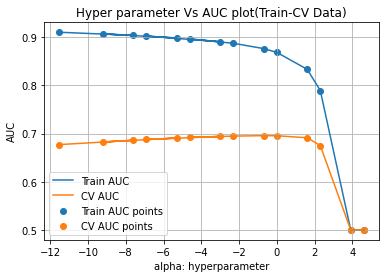

Best alpha: 0.5


In [369]:
#For Set 1
#Find the Hyperparameter using RandomSearchCv
BestParameter = multinomialNB_RandonSearchCV(X_Tr,Y_Train)

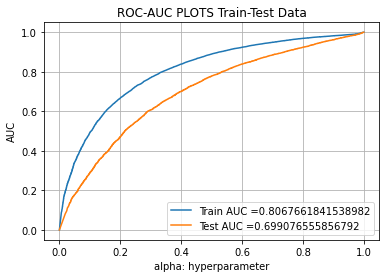

In [370]:
#Test the Model and get predicted probabiltites
Train_FPR, Train_TPR, Tr_Thresholds,Test_FPR, Test_TPR, Te_Thresholds,Y_Train_Pred,Y_Test_Pred,Feature_Log_Proba = multinomialNB_TestingData(X_Tr,Y_Train,X_Te,Y_Test,BestParameter)

In [371]:
#Get the best threshold
best_t = find_best_threshold(Tr_Thresholds, Train_FPR, Train_TPR)

the maximum value of tpr*(1-fpr) 0.5443850233497763 for threshold 0.584


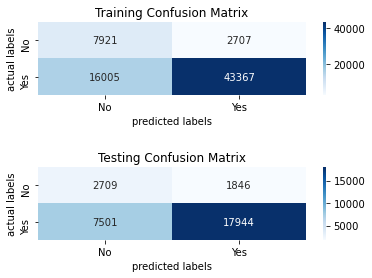

In [372]:
#Find Confusion Matrix and Display them
Train_CM = confusion_matrix(Y_Train, predict_with_best_t(Y_Train_Pred, best_t))
Test_CM = confusion_matrix(Y_Test, predict_with_best_t(Y_Test_Pred, best_t))
HeatMapForConfusionMatrix(Train_CM,Test_CM)

### Getting Dataset Ready for Set 2(Tf-IDF on essay column)

In [373]:
#Set 2
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features = 50000)
vectorizer.fit(X_Train['essay'].values)
X_Train_Essay_BoW = vectorizer.transform(X_Train['essay'].values)
X_Test_Essay_BoW = vectorizer.transform(X_Test['essay'].values)
print(X_Train_Essay_BoW.shape)
print(X_Test_Essay_BoW.shape)

#create dataframe to b processed for set 2
#Stacking all the features column wise
X_Tr = hstack((X_Train_Essay_BoW ,X_Train_School_State,X_Train_Teacher_Prefix,X_Train_Project_Grade_Category,X_Train_Clean_Categories,X_Train_Clean_Subcategories,X_Train_Price,X_Train_TNOPPP)).tocsr()
X_Te =  hstack((X_Test_Essay_BoW ,X_Test_School_State,X_Test_Teacher_Prefix,X_Test_Project_Grade_Category,X_Test_Clean_Categories,X_Test_Clean_Subcategories,X_Test_Price,X_Test_TNOPPP)).tocsr()




(70000, 50000)
(30000, 50000)


## 1.5.2 Apply all Operations Set 2

   param_alpha  mean_train_score  mean_test_score
0        1e-05          0.828226         0.685525
1       0.0005          0.826890         0.687011
2       0.0001          0.827537         0.686440
3        0.005          0.825366         0.687576
4        0.001          0.826541         0.687223
5         0.05          0.820107         0.687042
6         0.01          0.824523         0.687627
7          0.1          0.815723         0.685979
8          0.5          0.788668         0.675881
9            1          0.761565         0.663109
10           5          0.648402         0.603625
11          10          0.604535         0.579261
12          50          0.556687         0.549657
13         100          0.546300         0.541967


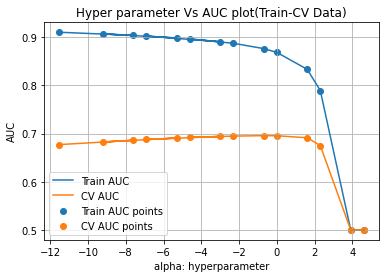

Best alpha: 0.5


In [374]:
#Find the Hyperparameter using RandomSearchCv
BestParameter = multinomialNB_RandonSearchCV(X_Tr,Y_Train)

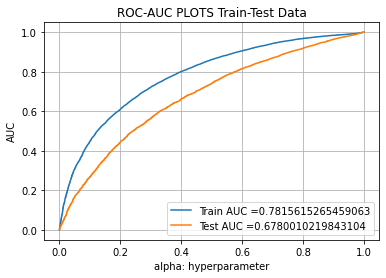

In [375]:
#Test the Model and get predicted probabiltites
Train_FPR, Train_TPR, Tr_Thresholds,Test_FPR, Test_TPR, Te_Thresholds,Y_Train_Pred,Y_Test_Pred,Feature_Log_Proba = multinomialNB_TestingData(X_Tr,Y_Train,X_Te,Y_Test,BestParameter)

In [376]:
#Get the best threshold
best_t = find_best_threshold(Tr_Thresholds, Train_FPR, Train_TPR)

the maximum value of tpr*(1-fpr) 0.5066012360181593 for threshold 0.553


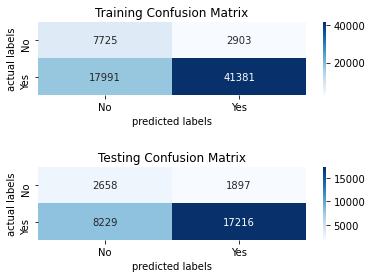

In [377]:
#Find Confusion Matrix and Display them
Train_CM = confusion_matrix(Y_Train, predict_with_best_t(Y_Train_Pred, best_t))
Test_CM = confusion_matrix(Y_Test, predict_with_best_t(Y_Test_Pred, best_t))
HeatMapForConfusionMatrix(Train_CM,Test_CM)

## 1.5.3 Finding Top 20 features For both class

In [378]:
#Get top 20 features from set 2
negativeClass = Feature_Log_Proba[0]
positiveClass = Feature_Log_Proba[1]
indexes_for_negative_class_descending = np.argsort(negativeClass)[::-1]
indexes_for_positive_class_descending = np.argsort(positiveClass)[::-1]

#make list of features
list_of_features = []
list_of_features.extend(vectorizer.get_feature_names())
list_of_features.extend(vectorizer_school_state.get_feature_names())
list_of_features.extend(vectorizer_teacher_prefix.get_feature_names())
list_of_features.extend(vectorizer_project_grade_category.get_feature_names())
list_of_features.extend(vectorizer_clean_categories.get_feature_names())
list_of_features.extend(vectorizer_clean_subcategories.get_feature_names())
list_of_features.append('Price')
list_of_features.append('teacher_number_of_previously_posted_projects')
print('Top 20 Features for positive class:')
for index in indexes_for_positive_class_descending[0:20]:
    print(list_of_features[index])
print('='*127)
print('Top 20 Features for negative class:')
for index in indexes_for_negative_class_descending[0:20]:
    print(list_of_features[index])

Top 20 Features for positive class:
mrs
literacy_language
grades_prek_2
math_science
ms
grades_3_5
literacy
mathematics
literature_writing
grades_6_8
ca
health_sports
specialneeds
specialneeds
appliedlearning
health_wellness
grades_9_12
appliedsciences
mr
music_arts
Top 20 Features for negative class:
mrs
literacy_language
grades_prek_2
math_science
ms
grades_3_5
literacy
mathematics
literature_writing
grades_6_8
specialneeds
specialneeds
ca
health_sports
appliedlearning
appliedsciences
grades_9_12
mr
music_arts
health_wellness


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [379]:
summary = pd.DataFrame({'Vectorizer':['B0W','Tfidf'],'Model':['Multinomial Naive Bayes','Multinomial Naive Bayes'],'HyperParameter':[0.5,0.5],'auc':[0.69,0.67]})
summary

,Vectorizer,Model,HyperParameter,auc
0,B0W,Multinomial Naive Bayes,0.5,0.69
1,Tfidf,Multinomial Naive Bayes,0.5,0.67
